In [1]:
%cd /content/drive/MyDrive/data-scientist-take-home/data

/content/drive/MyDrive/data-scientist-take-home/data


**Library Imports**

In [2]:
#libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

**Data loading and overview**

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
train_df.shape

(1460, 81)

# Data Cleaning

1.   Remove the columns with many null values
2.   Fill the columns with rare null values with the means of the columns
3.   Remove the columns not correlated with the SalePrice
4.   Remove the outlier samples



In [7]:
num_null_in_col = train_df.isnull().sum() #columnwise sum

print('\n NULL column and number of them \n', 
      num_null_in_col[num_null_in_col > 0].sort_values(ascending=False))


 NULL column and number of them 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [8]:
train_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
             , axis = 1, inplace = True)
test_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
             , axis = 1, inplace = True)

# Replace non-drop numeric NULL columns with average values.
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

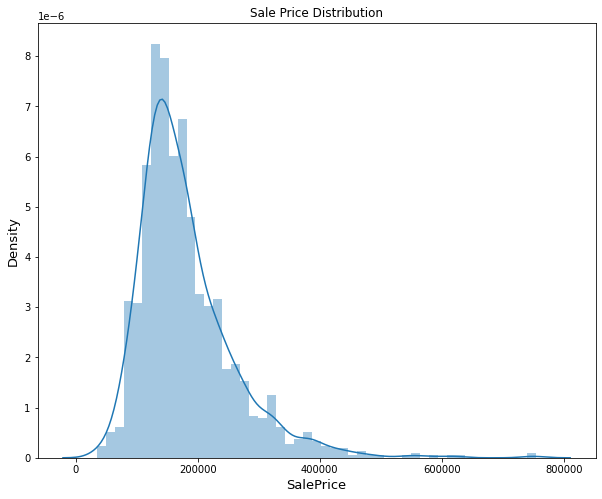

In [9]:
plt.figure(figsize=(10,8))
plt.title('Sale Price Distribution')
sns.distplot(train_df['SalePrice'])
plt.ylabel('Density', fontsize=13)
plt.xlabel('SalePrice', fontsize=13)

plt.show()

Remove the skewness in SalePrice

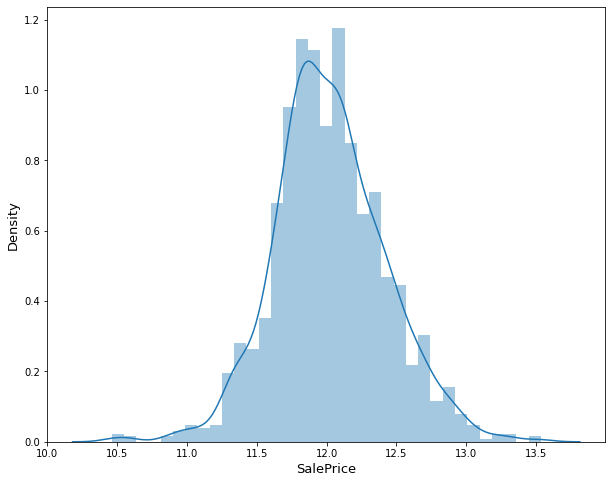

In [10]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

plt.figure(figsize=(10,8))
sns.distplot(train_df['SalePrice'])
plt.ylabel('Density', fontsize=13)
plt.xlabel('SalePrice', fontsize=13)

plt.show()

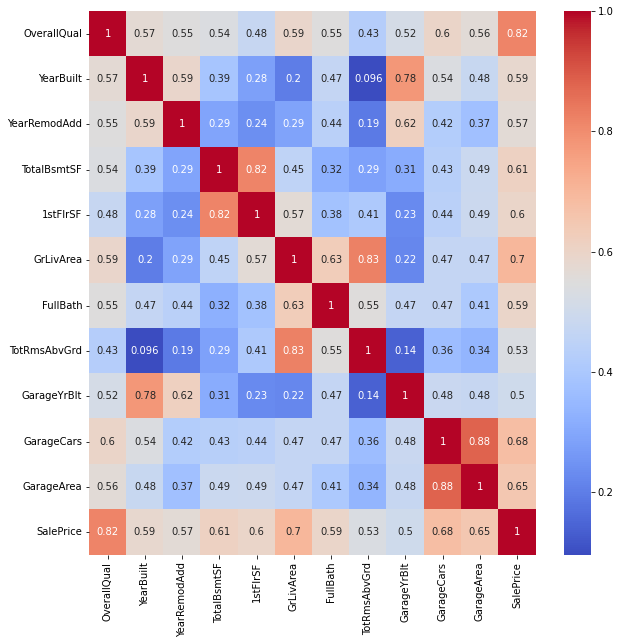

In [11]:
corr_matrix = train_df.corr()
top_corr_features = corr_matrix.index[abs(corr_matrix["SalePrice"])>0.5]
plt.figure(figsize=(10,10))

g = sns.heatmap(train_df[top_corr_features].corr(),
                annot=True,
                cmap="coolwarm")

In [12]:
print("features highly correlated with the target")

corr_matrix = train_df.corr()

#Sort in ascending order
corr_matrix["SalePrice"].sort_values(axis=0, ascending=False)

features highly correlated with the target


SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
BsmtFinSF1       0.372023
LotFrontage      0.336156
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

In [13]:
corr_matrix_2 = pd.DataFrame(corr_matrix.iloc[-1,:]).T

throw_away_col = []
for col in corr_matrix_2:
    if abs(corr_matrix_2[col][0]) <= 0.15:
        throw_away_col.append(col)
print(throw_away_col)

['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [14]:
train_df.shape

(1460, 76)

In [15]:
test_id = test_df['Id']

In [16]:
train_df.drop(['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
             , axis = 1, inplace = True)

test_df.drop(['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
             , axis = 1, inplace = True)

In [17]:
train_df.shape

(1460, 62)

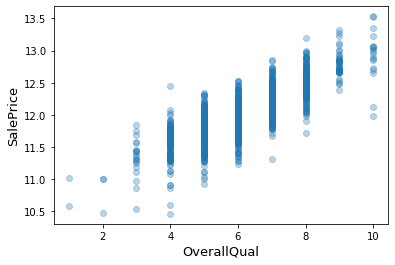

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['OverallQual'], y = train_df['SalePrice'], alpha = 0.3)
plt.xlabel('OverallQual', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

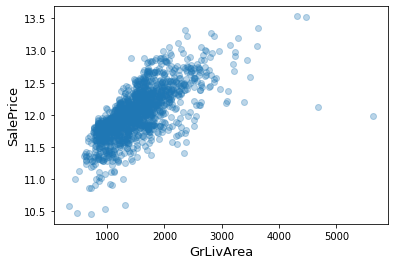

In [19]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'], alpha = 0.3)
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

In [20]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>3500) | (train_df['SalePrice']<10.7)].index)

In [21]:
train_df.shape

(1449, 62)

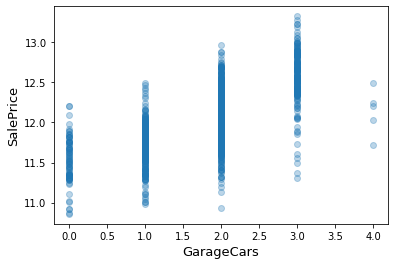

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GarageCars'], y = train_df['SalePrice'], alpha = 0.3)

plt.xlabel('GarageCars', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)
plt.show()

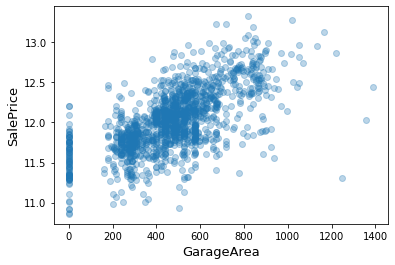

In [23]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GarageArea'], y = train_df['SalePrice'], alpha = 0.3)
plt.xlabel('GarageArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

In [24]:
train_df = train_df.drop(train_df[(train_df['GarageArea']>1200)].index)

In [25]:
train_df.shape

(1445, 62)

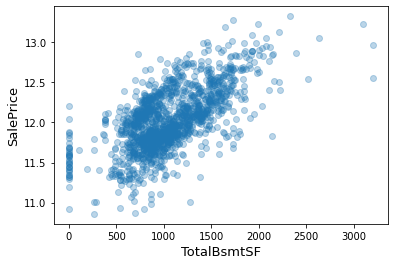

In [26]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['TotalBsmtSF'], y = train_df['SalePrice'], alpha = 0.3)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

In [27]:
train_df = train_df.drop(train_df[(train_df['TotalBsmtSF'] > 2500)].index)

In [28]:
train_df.shape

(1440, 62)

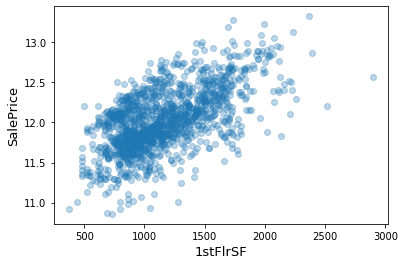

In [29]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['1stFlrSF'], y = train_df['SalePrice'], alpha = 0.3)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('1stFlrSF', fontsize=13)

plt.show()

In [30]:
train_df = train_df.drop(train_df[(train_df['1stFlrSF'] > 2400)].index)

In [31]:
train_df.shape

(1438, 62)

In [32]:
test_df.shape

(1459, 61)

# Data Pre-processing


1.   One hot Encoding the columns that are categorical



In [33]:
s = (train_df.dtypes == 'object')
object_cols = list(s[s].index)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(train_df[object_cols]))
OH_cols.index = train_df.index
OH_cols.columns = OH_encoder.get_feature_names(object_cols)
train_df = train_df.drop(object_cols, axis=1)
train_df = pd.concat([train_df, OH_cols], axis=1)

In [34]:
OH_cols = pd.DataFrame(OH_encoder.transform(test_df[object_cols]))
OH_cols.index = test_df.index
OH_cols.columns = OH_encoder.get_feature_names(object_cols)
test_df = test_df.drop(object_cols, axis=1)
test_df = pd.concat([test_df, OH_cols], axis=1)

In [35]:
train_df.shape

(1438, 267)

In [36]:
test_df.shape

(1459, 266)

# Train-Dev split

In [37]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train , random_state=0, test_size=0.2)
print(x_train.shape, x_dev.shape, y_train.shape, y_dev.shape)

(1150, 266) (288, 266) (1150,) (288,)


Root Mean Square Error

In [39]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Models

In [40]:
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=27)

In [41]:

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=27)

In [42]:
ridge_alphas = [1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 
                0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=KFold(n_splits=12, shuffle = True, random_state = 27)))

In [43]:
from sklearn.svm import SVR

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

In [44]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=27)  



In [45]:
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=27)

## Training the models and calculating the error on validation set

In [46]:
for model in [lightgbm, xgboost, ridge, svr, gbr, rf]:
    print("Model: ", model)
    model.fit(x_train, y_train)
    label_dev = model.predict(x_dev)
    cv_error = rmse(label_dev, y_dev)
    print(cv_error,"\n")


Model:  LGBMRegressor(bagging_fraction=0.8, bagging_freq=4, bagging_seed=8,
              feature_fraction=0.2, feature_fraction_seed=8, learning_rate=0.01,
              max_bin=200, min_sum_hessian_in_leaf=11, n_estimators=7000,
              num_leaves=6, objective='regression', random_state=27,
              verbose=-1)
0.10519951858165984 

Model:  XGBRegressor(colsample_bytree=0.7, gamma=0.6, learning_rate=0.01, max_depth=4,
             min_child_weight=0, n_estimators=6000, nthread=-1, random_state=27,
             reg_alpha=6e-05, seed=27, subsample=0.7)
[06:54:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.12360047299148968 

Model:  Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.0e-10, 1.0e-08, 9.0e-04, 7.0e-04, 5.0e-04, 3.0e-04, 1.0e-04,
       1.0e-03, 5.0e-02, 1.0e-02, 1.0e-01, 3.0e-01, 1.0e+00, 3.0e+00,
       5.0e+00, 1.0e+01

Since the error on the validation set is lowest for GradientBosstingRegressor, it is used to predict the SalePrice for the test set

In [47]:
y_pred = gbr.predict(test_df)

Since the SalePrice used to train the models were log1p operated (i.e log(1 + x)), this needs to be reversed to calculate the actual price

In [48]:
y_pred = np.expm1(y_pred)

In [49]:
submission_df = pd.DataFrame({'Id': test_id, 'SalePrice': y_pred})

In [50]:
submission_df.head(10)

,Id,SalePrice
0,1461,121450.146163
1,1462,160187.810648
2,1463,192621.073506
3,1464,193950.947722
4,1465,185533.330973
5,1466,179640.682756
6,1467,168566.285261
7,1468,167490.859306
8,1469,186215.194258
9,1470,132985.413914


In [51]:
submission_df.to_csv("submission.csv", index=False)

# Test Set Visualizations

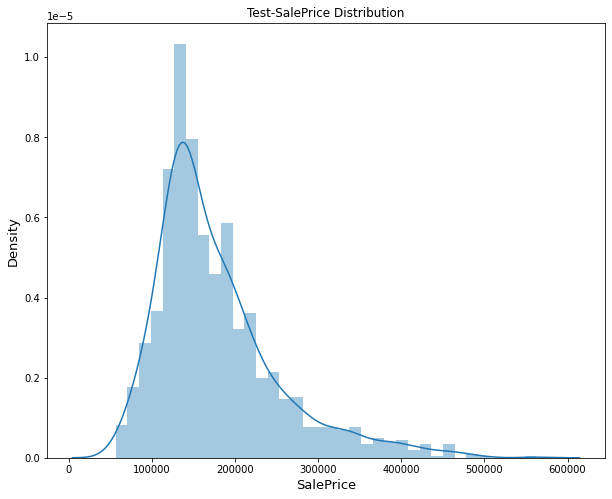

In [52]:
plt.figure(figsize=(10,8))
plt.title('Test-SalePrice Distribution')
sns.distplot(y_pred)
plt.ylabel('Density', fontsize=13)
plt.xlabel('SalePrice', fontsize=13)

plt.show()

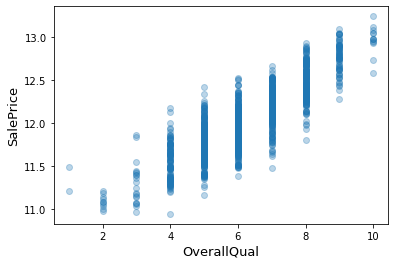

In [53]:
fig, ax = plt.subplots()
ax.scatter(x = test_df['OverallQual'], y = np.log1p(y_pred), alpha = 0.3)
plt.xlabel('OverallQual', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

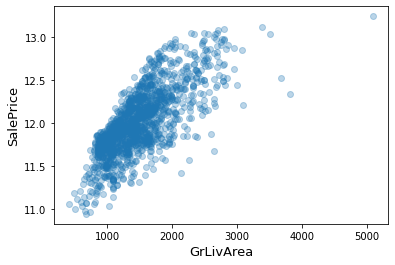

In [54]:
fig, ax = plt.subplots()
ax.scatter(x = test_df['GrLivArea'], y = np.log1p(y_pred), alpha = 0.3)
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()